In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import kagglehub


In [47]:
path_animals10 = kagglehub.dataset_download("alessiocorrado99/animals10")
print("Path to animals10 dataset files:", path_animals10)


100%|██████████| 586M/586M [00:09<00:00, 61.6MB/s]

Extracting files...


Path to animals10 dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [2]:
#paths and parameters
DATA_DIR = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 3
NUM_CLASSES = 2

In [3]:
# สเปน เป็น อังกฤษ
class_names = ['cane', 'gatto']

translations = {
    'cane': 'dog',
    'gatto': 'cat'
}

In [4]:
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.exists(class_dir):
        raise FileNotFoundError(f"Directory not found: {class_dir}")
    print(f"Found directory: {class_name} ({translations[class_name]})")
    # Count images
    image_count = len([name for name in os.listdir(class_dir)
                       if os.path.isfile(os.path.join(class_dir, name)) and
                       name.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(f"  - Contains {image_count} images")

Found directory: cane (dog)
  - Contains 4863 images
Found directory: gatto (cat)
  - Contains 1668 images


In [5]:
import shutil

BINARY_DATA_DIR = "/tmp/dog_cat_dataset"
os.makedirs(BINARY_DATA_DIR, exist_ok=True)

# train and validation dir
TRAIN_DIR = os.path.join(BINARY_DATA_DIR, "train")
VAL_DIR = os.path.join(BINARY_DATA_DIR, "validation")

In [6]:
for class_name in class_names:
    os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, class_name), exist_ok=True)

# 80 training 20 validation
for class_name in class_names:
    source_dir = os.path.join(DATA_DIR, class_name)
    files = [f for f in os.listdir(source_dir)
             if os.path.isfile(os.path.join(source_dir, f)) and
             f.lower().endswith(('.png', '.jpg', '.jpeg'))]


    split_idx = int(len(files) * 0.8)
    train_files = files[:split_idx]
    val_files = files[split_idx:]

    # training
    for file in train_files:
        src_path = os.path.join(source_dir, file)
        dst_path = os.path.join(TRAIN_DIR, class_name, file)
        shutil.copy(src_path, dst_path)

    # Validation
    for file in val_files:
        src_path = os.path.join(source_dir, file)
        dst_path = os.path.join(VAL_DIR, class_name, file)
        shutil.copy(src_path, dst_path)

    print(f"Copied {len(train_files)} images to training and {len(val_files)} to validation for {class_name}")


Copied 3890 images to training and 973 to validation for cane
Copied 1334 images to training and 334 to validation for gatto


In [7]:
# augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
# rescaling validation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load aug training dataset
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 5224 images belonging to 2 classes.


In [9]:
# Load and prepare the validation dataset
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1307 images belonging to 2 classes.


In [10]:
# Define callbacks for training
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)
]


In [11]:
# Build CNN model
model = Sequential([
    # First
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Second
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Third
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Flatten
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Train
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 2846s 17s/step - accuracy: 0.5999 - loss: 0.9887 - val_accuracy: 0.5227 - val_loss: 0.7841 - learning_rate: 0.0010
Epoch 2/3
  1/163 ━━━━━━━━━━━━━━━━━━━━ 1:05:54 24s/step - accuracy: 0.7812 - loss: 0.5771

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 851ms/step - accuracy: 0.7812 - loss: 0.5771 - val_accuracy: 0.5297 - val_loss: 0.8103 - learning_rate: 0.0010
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 3199s 20s/step - accuracy: 0.6907 - loss: 0.7065 - val_accuracy: 0.7406 - val_loss: 0.5445 - learning_rate: 0.0010


In [14]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation loss: {val_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.8922 - loss: 0.3991
Validation accuracy: 0.7314
Validation loss: 0.5542


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

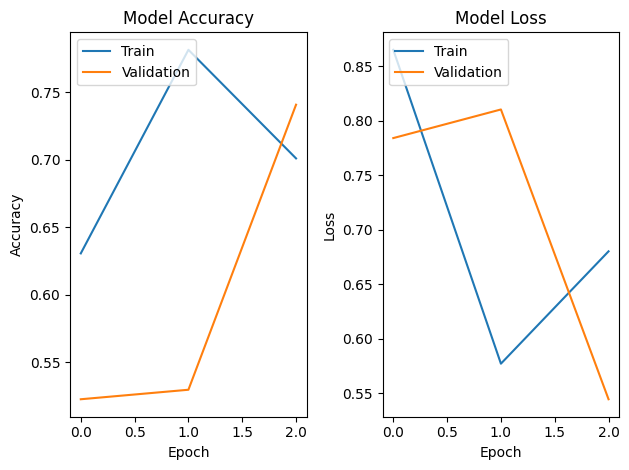

In [15]:
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# predictions
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

class_indices = validation_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()}  # Invert the dictionary

print("\nClassification Report:")
print(classification_report(y_true, y_pred,
      target_names=[f"{name} ({translations[name]})" for name in class_names]))


41/41 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step

Classification Report:
              precision    recall  f1-score   support

  cane (dog)       0.76      0.93      0.84       973
 gatto (cat)       0.43      0.16      0.23       334

    accuracy                           0.73      1307
   macro avg       0.60      0.54      0.53      1307
weighted avg       0.68      0.73      0.68      1307



Please upload a dog or cat image (JPEG/PNG)


Saving Cat Image.jpg to Cat Image.jpg

Image: Cat Image.jpg


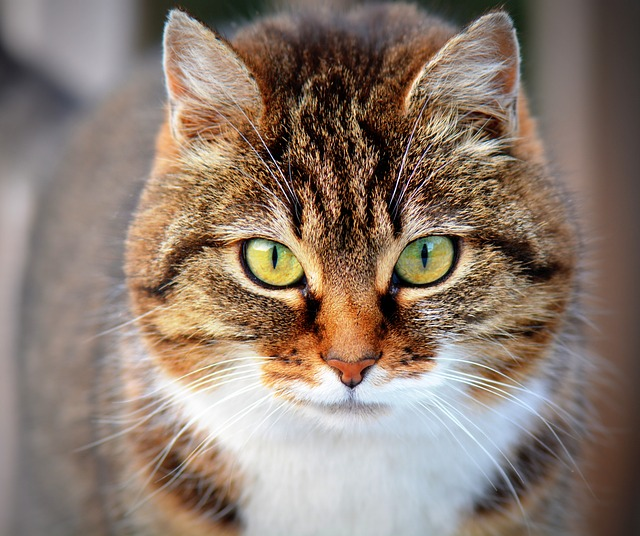

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


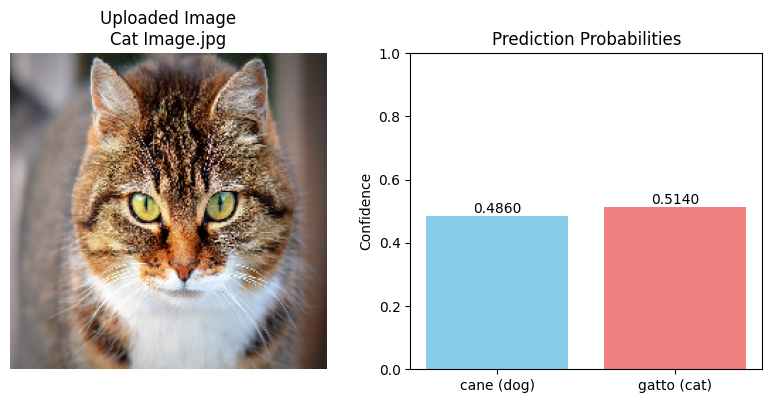


Prediction Result:
- Class: gatto (cat)
- Confidence: 0.5140




In [27]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import Image, display
import tensorflow as tf

def predict_uploaded_image():

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nImage: {filename}")
        display(Image(filename, width=300))
        img = tf.keras.preprocessing.image.load_img(
            filename,
            target_size=(224, 224)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction[0])
        confidence = np.max(prediction[0])

        class_names = {0: 'cane (dog)', 1: 'gatto (cat)'}
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Uploaded Image\n{filename}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        bars = plt.bar(class_names.values(), prediction[0], color=['skyblue', 'lightcoral'])
        plt.title('Prediction Probabilities')
        plt.ylabel('Confidence')
        plt.ylim(0, 1)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.4f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        print(f"\nPrediction Result:")
        print(f"- Class: {class_names[predicted_class]}")
        print(f"- Confidence: {confidence:.4f}")
        print("\n" + "="*50 + "\n")

print("Please upload a dog or cat image (JPEG/PNG)")
predict_uploaded_image()